# Equidistant classes and cost matrix

In this Notebook we test the performance of various models in a two dimensional dataset with three equidistant classes. The idea is to extend the dataset generator to incorporate a hierarchy on the class difficulty, and to evaluate models that consider a hierarchical cost that is not correlated to the intrinsic hierarchy of difficulty (e.g. a class should have more errors if it overlaps more with another class).

The tested 

The current data generator only generates Gaussian distributions in one dimension for two class problems, and two dimensions for three class problems.

# Dataset generator

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


class EquidistantDataset(object):
    def __init__(self, n_classes=3, random_state=42):
        self.n_classes = n_classes
        self.random_state = random_state
        
    def _initialise(self):
        if not hasattr(self, 'has_been_initialised'):
            self.n_features = self.n_classes - 1
            # TODO come up with general formula
            if self.n_classes == 2:
                self.centers = [[-0.5], [0.5]]
            elif self.n_classes == 3:
                self.centers = np.array([
                    [0, 0.5/np.cos(np.radians(30))],
                    [-0.5, -0.5*np.tan(np.radians(30))],
                    [+0.5, -0.5*np.tan(np.radians(30))]])
                np.random.seed(self.random_state)
                self.rotation_angle = np.random.rand(1)
                self.rotation = np.array([[np.cos(self.rotation_angle), -np.sin(self.rotation_angle)],
                                          [np.sin(self.rotation_angle),  np.cos(self.rotation_angle)]
                                         ])
                self.centers = np.inner(self.rotation.reshape(2, 2), self.centers).T
            else:
                self.centers = np.zeros(shape=(self.n_classes, self.n_features))
            self.cluster_std = 0.25
            self.sample_iteration = 0
            self.has_been_initialised = True
        
    def sample(self, n_samples):
        self._initialise()
        self.sample_iteration += 1
        return make_blobs(n_samples=n_samples, n_features=self.n_features,
                          centers=self.centers, cluster_std=self.cluster_std,
                          shuffle=True,
                          random_state=self.random_state + self.sample_iteration,
                          return_centers=False)

## Example of two classes

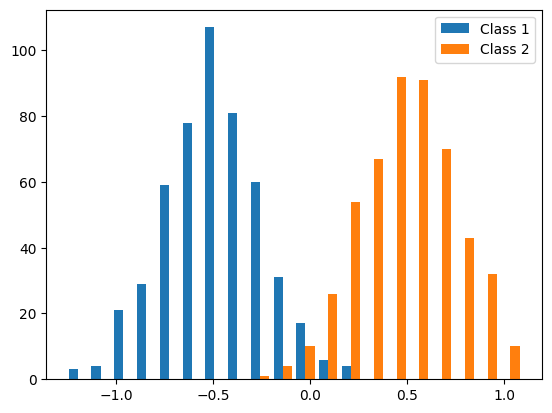

In [2]:
generator = EquidistantDataset(n_classes=2)
X, y = generator.sample(1000)

plt.hist([X[y==0].flatten(), X[y==1].flatten()], bins=20, label=[r'Class 1', r'Class 2'])
plt.legend()

## Example of three classes

/tmp/ipykernel_412608/3984132691.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


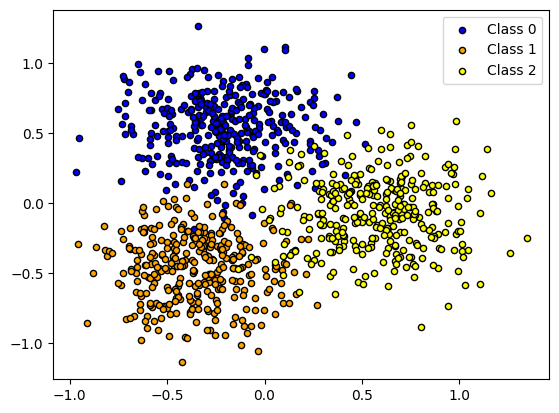

In [3]:
generator = EquidistantDataset(n_classes=3)
X_train, y_train = generator.sample(1000)

colors = ['blue', 'orange', 'yellow']

for i, color in enumerate(colors):
    idx = np.where(y_train == i)
    plt.scatter(
        X_train[idx, 0],
        X_train[idx, 1],
        c=color,
        label='Class ' + str(i),
        cmap=plt.cm.Paired,
        edgecolor="black",
        s=20,
    )
plt.legend()

# Decision tree

Now we test the performance of a scikit-learn decision tree on the generated dataset.

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

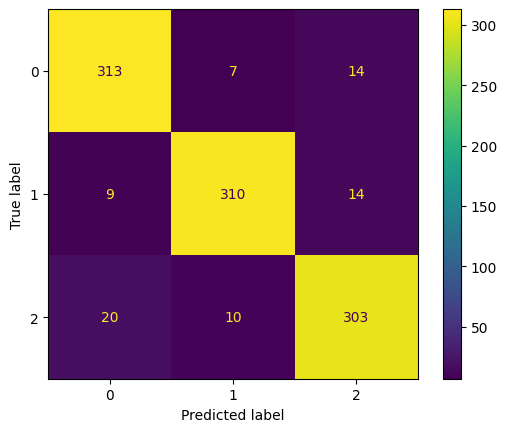

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test, y_test = generator.sample(1000)
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

/tmp/ipykernel_412608/1056290875.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


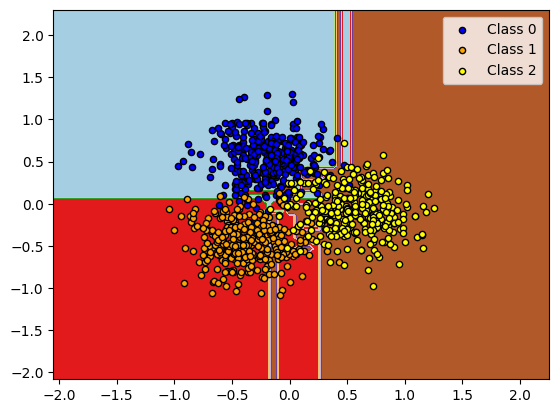

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    clf,
    X_test,
    cmap=plt.cm.Paired,
    response_method="predict"
)
plt.axis("tight")

colors = ['blue', 'orange', 'yellow']

for i, color in zip(clf.classes_, colors):
    idx = np.where(y_test == i)
    plt.scatter(
        X_test[idx, 0],
        X_test[idx, 1],
        c=color,
        label='Class ' + str(i),
        cmap=plt.cm.Paired,
        edgecolor="black",
        s=20,
    )
plt.legend()

## Multiple repetitions

The dataset generator has some random components, here we repeat the generation multiple times and aggregate the performance of each decision tree.

In [7]:
n_repetitions = 100
n_samples = 1000

cm_list = []
for r in range(n_repetitions):
    generator = EquidistantDataset(n_classes=3, random_state=100+r)
    X_train, y_train = generator.sample(n_samples)
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    X_test, y_test = generator.sample(n_samples)
    predictions = clf.predict(X_test)

    cm_list.append(confusion_matrix(y_test, predictions))

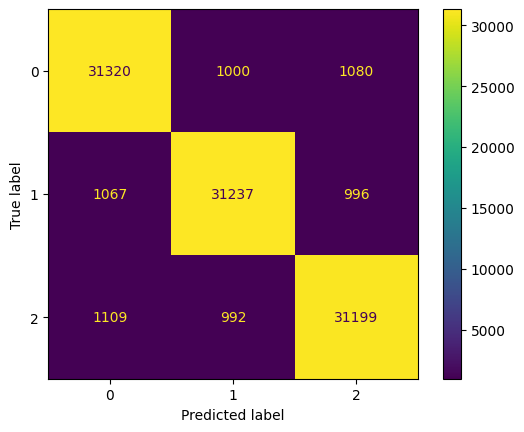

In [8]:
disp = ConfusionMatrixDisplay(np.sum(cm_list, axis=0))
disp.plot()

# PyTorch Multinomial Logistic Regression

We will use in the following experiments a Multinomial Logistic Regression implemented with PyTorch and using skorch to use the model as a scikit-learn probabilistic classifier.

In [9]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping


class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 3)
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x

    from skorch import NeuralNetBinaryClassifier, NeuralNetClassifier

model = NeuralNetClassifier(
    Model(input_dim=2),
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.0001,
    max_epochs=500,
    batch_size=10,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

print(model)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=Model(
    (layer1): Linear(in_features=2, out_features=3, bias=True)
  ),
)


## Numpy arrays to tensors

PyTorch models require PyTorch tensors in order to train. Here we convert every numpy array into a PyTorch tensor.

In [10]:
X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

In [11]:
model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1245       0.3350        1.1258  0.0847
      2        1.1231       0.3350        1.1243  0.0570
      3        1.1217       0.3350        1.1229  0.0540
      4        1.1203       0.3350        1.1214  0.0583
      5        1.1189       0.3350        1.1200  0.0525
      6        1.1175       0.3350        1.1185  0.0546
      7        1.1161       0.3350        1.1171  0.0528
      8        1.1147       0.3350        1.1156  0.0521
      9        1.1133       0.3350        1.1141  0.0518
     10        1.1119       0.3350        1.1127  0.0521
     11        1.1105       0.3350        1.1112  0.0522
     12        1.1090       0.3350        1.1097  0.0518
     13        1.1076       0.3350        1.1082  0.0541
     14        1.1062       0.3350        1.1068  0.0522
     15        1.1047       0.3350        1.1053  0.0519
     16        1.1033       0.3

    103        0.9641       0.7600        0.9560  0.0530
    104        0.9624       0.7600        0.9542  0.0564
    105        0.9608       0.7700        0.9524  0.0542
    106        0.9591       0.7750        0.9507  0.0569
    107        0.9575       0.7750        0.9489  0.0549
    108        0.9558       0.7750        0.9471  0.0529
    109        0.9542       0.7800        0.9454  0.0525
    110        0.9526       0.7900        0.9436  0.0530
    111        0.9509       0.7950        0.9419  0.0531
    112        0.9493       0.7950        0.9401  0.0580
    113        0.9477       0.8100        0.9384  0.0536
    114        0.9461       0.8200        0.9366  0.0595
    115        0.9444       0.8250        0.9349  0.0553
    116        0.9428       0.8300        0.9331  0.0576
    117        0.9412       0.8400        0.9314  0.0589
    118        0.9396       0.8400        0.9297  0.0574
    119        0.9380       0.8400        0.9280  0.0568
    120        0.9364       0.8

    209        0.8161       0.9600        0.7994  0.0516
    210        0.8151       0.9600        0.7983  0.0518
    211        0.8140       0.9600        0.7972  0.0530
    212        0.8129       0.9600        0.7961  0.0527
    213        0.8119       0.9600        0.7950  0.0521
    214        0.8108       0.9600        0.7939  0.0520
    215        0.8098       0.9600        0.7929  0.0522
    216        0.8088       0.9600        0.7918  0.0525
    217        0.8077       0.9600        0.7907  0.0571
    218        0.8067       0.9600        0.7897  0.0529
    219        0.8057       0.9650        0.7886  0.0533
    220        0.8047       0.9650        0.7876  0.0534
    221        0.8037       0.9650        0.7866  0.0528
    222        0.8027       0.9650        0.7855  0.0525
    223        0.8017       0.9650        0.7845  0.0525
    224        0.8007       0.9650        0.7835  0.0526
    225        0.7997       0.9650        0.7825  0.0528
    226        0.7987       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=2, out_features=3, bias=True)
  ),
)

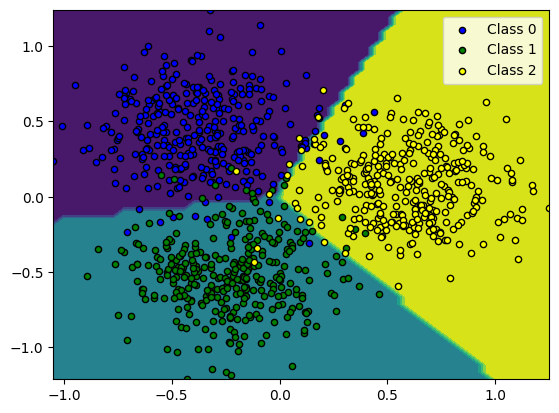

In [12]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary_pytorch(X, y, model):
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max()),
        np.linspace(X[:, 1].min(), X[:, 1].max())
    )

    feature_1 = Variable(torch.from_numpy(feature_1)).float()
    feature_2 = Variable(torch.from_numpy(feature_2)).float()
    grid = Variable(torch.from_numpy(np.vstack([feature_1.ravel(), feature_2.ravel()]).T)).float()

    y_pred = np.reshape(model.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot()
    plt.axis("tight")

    colors = ['blue', 'green', 'yellow']

    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label='Class ' + str(i),
            edgecolor="black",
            s=20,
        )
    plt.legend()
    
plot_decision_boundary_pytorch(X_test, y_test, model)

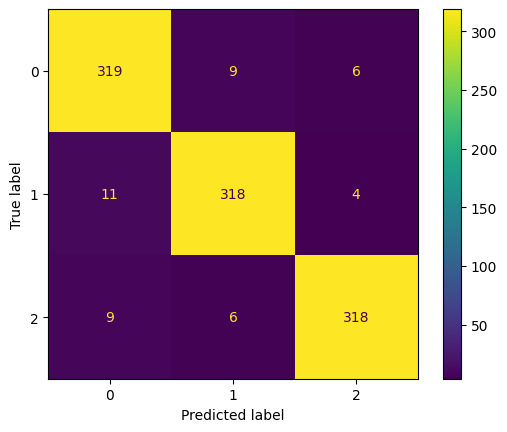

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Train a neural network with specified loss

## True class absolute loss

The following is an example defining an absolute loss, only for the true positive label

$$
\Psi (\mathbf{y}, \mathbf{q}) = 1 - \sum_{i=1}^K y_i*q_i  \qquad \in [0, 1]
$$

which for a perfect prediction for $y_i = 1$ and $q_i = 1$ has the smallest loss $\Psi (\mathbf{y}, \mathbf{q}) = 0$.

In [14]:
class TrueClassAbsoluteLoss(nn.Module):
    def __init__(self):
        super(TrueClassAbsoluteLoss, self).__init__()
    
    def forward(self, output, target):
        target = torch.LongTensor(target)
        target = nn.functional.one_hot(target, num_classes=3).float()
        loss = torch.einsum('ij,ij->i', target, output)
        #print(target)
        #print(output)
        #print(loss)
        loss = 1 - loss.mean()
        return loss


model = NeuralNetClassifier(
    Model(input_dim=2),
    criterion=TrueClassAbsoluteLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6361       0.4100        0.6262  0.0693
      2        0.6161       0.5400        0.6045  0.0735
      3        0.5958       0.6600        0.5826  0.0732
      4        0.5754       0.7750        0.5609  0.0657
      5        0.5554       0.8650        0.5395  0.0656
      6        0.5357       0.9300        0.5187  0.0655
      7        0.5167       0.9350        0.4985  0.0659
      8        0.4982       0.9300        0.4791  0.0662
      9        0.4805       0.9350        0.4605  0.0696
     10        0.4635       0.9400        0.4427  0.0663
     11        0.4472       0.9350        0.4256  0.0656
     12        0.4315       0.9450        0.4093  0.0664
     13        0.4166       0.9500        0.3937  0.0663
     14        0.4022       0.9550        0.3788  0.0675
     15        0.3885       0.9550        0.3646  0.0626
     16        0.3755       0.9

    107        0.0846       0.9800        0.0637  0.0668
    108        0.0840       0.9800        0.0631  0.0666
    109        0.0834       0.9800        0.0626  0.0663
    110        0.0829       0.9800        0.0620  0.0683
    111        0.0823       0.9800        0.0615  0.0671
    112        0.0818       0.9800        0.0609  0.0731
    113        0.0813       0.9800        0.0604  0.0652
    114        0.0808       0.9800        0.0599  0.0648
    115        0.0803       0.9800        0.0594  0.0674
    116        0.0798       0.9800        0.0589  0.0733
    117        0.0793       0.9800        0.0584  0.0673
    118        0.0788       0.9800        0.0579  0.0668
    119        0.0784       0.9800        0.0575  0.0664
    120        0.0779       0.9800        0.0570  0.0678
    121        0.0775       0.9800        0.0566  0.0655
    122        0.0771       0.9800        0.0562  0.0708
    123        0.0766       0.9800        0.0557  0.0660
    124        0.0762       0.9

    217        0.0578       0.9750        0.0370  0.0823
    218        0.0577       0.9750        0.0369  0.0726
    219        0.0576       0.9750        0.0369  0.0698
    220        0.0576       0.9750        0.0368  0.0706
    221        0.0575       0.9750        0.0367  0.0711
    222        0.0574       0.9750        0.0366  0.0710
    223        0.0573       0.9750        0.0365  0.0709
    224        0.0572       0.9750        0.0364  0.0707
    225        0.0571       0.9750        0.0364  0.0711
    226        0.0570       0.9750        0.0363  0.0706
    227        0.0570       0.9750        0.0362  0.0770
    228        0.0569       0.9750        0.0361  0.0668
    229        0.0568       0.9750        0.0361  0.0783
    230        0.0567       0.9750        0.0360  0.0795
    231        0.0566       0.9750        0.0359  0.0673
    232        0.0565       0.9750        0.0358  0.0686
    233        0.0565       0.9750        0.0358  0.0771
    234        0.0564       0.9

    327        0.0516       0.9750        0.0314  0.0718
    328        0.0516       0.9750        0.0314  0.0737
    329        0.0515       0.9750        0.0314  0.0721
Stopping since valid_loss has not improved in the last 10 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=2, out_features=3, bias=True)
  ),
)

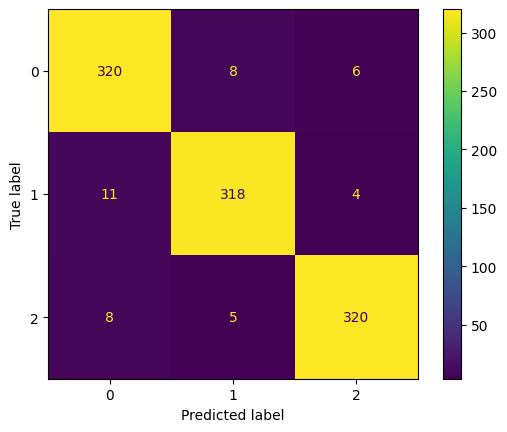

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

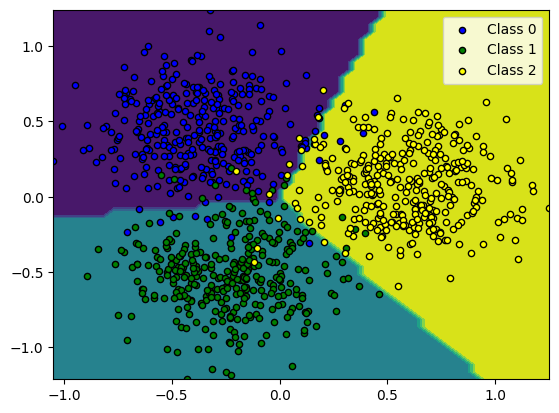

In [16]:
plot_decision_boundary_pytorch(X_test, y_test, model)

## Cross entropy


The following is an example defining cross entropy, only for the true positive label

$$
\Psi (\mathbf{y}, \mathbf{q}) = - \sum_{i=1}^K y_i*q_i \qquad \in [0, \infty)
$$

which for a perfect prediction for $y_i = 1$ and $q_i = 1$ has the smallest loss $\Psi (\mathbf{y}, \mathbf{q}) = 0$.

In [17]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
    
    def forward(self, output, target):
        target = torch.LongTensor(target)
        target = nn.functional.one_hot(target, num_classes=3).float()
        loss = -torch.einsum('ij,ij->i', target, torch.log(output))
        #print(target)
        #print(output)
        #print(loss)
        loss = loss.mean()
        return loss

model = NeuralNetClassifier(
    Model(input_dim=2),
    #criterion=torch.nn.BCEWithLogitsLoss,
    criterion=CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9996       0.3550        0.9628  0.0720
      2        0.9345       0.4600        0.8993  0.0723
      3        0.8779       0.5850        0.8434  0.0830
      4        0.8279       0.7300        0.7939  0.0769
      5        0.7836       0.8350        0.7497  0.0745
      6        0.7439       0.8850        0.7100  0.0764
      7        0.7082       0.9350        0.6742  0.0760
      8        0.6759       0.9700        0.6416  0.0764
      9        0.6464       0.9750        0.6118  0.0743
     10        0.6194       0.9750        0.5844  0.0761
     11        0.5945       0.9800        0.5592  0.0747
     12        0.5714       0.9800        0.5358  0.0745
     13        0.5500       0.9850        0.5141  0.0746
     14        0.5300       0.9850        0.4938  0.0795
     15        0.5113       0.9850        0.4749  0.0751
     16        0.4938       0.9

    108        0.1297       0.9750        0.0898  0.0738
    109        0.1291       0.9750        0.0891  0.0725
    110        0.1285       0.9750        0.0884  0.0731
    111        0.1279       0.9750        0.0878  0.0732
    112        0.1274       0.9750        0.0872  0.0740
    113        0.1268       0.9750        0.0865  0.0768
    114        0.1263       0.9750        0.0859  0.0752
    115        0.1258       0.9750        0.0853  0.0728
    116        0.1253       0.9750        0.0847  0.0760
    117        0.1248       0.9750        0.0842  0.0764
    118        0.1243       0.9750        0.0836  0.0747
    119        0.1239       0.9750        0.0831  0.0733
    120        0.1234       0.9750        0.0826  0.0763
    121        0.1230       0.9750        0.0820  0.0758
    122        0.1226       0.9750        0.0815  0.0738
    123        0.1222       0.9750        0.0810  0.0835
    124        0.1218       0.9750        0.0806  0.0799
    125        0.1214       0.9

    218        0.1070       0.9750        0.0605  0.0932
    219        0.1069       0.9750        0.0604  0.0842
    220        0.1069       0.9750        0.0603  0.0783
    221        0.1068       0.9750        0.0603  0.0778
    222        0.1068       0.9750        0.0602  0.0792
    223        0.1067       0.9750        0.0601  0.0791
    224        0.1067       0.9750        0.0600  0.0795
    225        0.1066       0.9750        0.0599  0.0808
    226        0.1066       0.9750        0.0598  0.0796
    227        0.1065       0.9750        0.0598  0.0816
    228        0.1065       0.9750        0.0597  0.0785
    229        0.1064       0.9750        0.0596  0.0790
    230        0.1064       0.9750        0.0595  0.0807
    231        0.1064       0.9750        0.0595  0.0797
    232        0.1063       0.9750        0.0594  0.0783
    233        0.1063       0.9750        0.0593  0.0760
    234        0.1062       0.9750        0.0592  0.0809
    235        0.1062       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=2, out_features=3, bias=True)
  ),
)

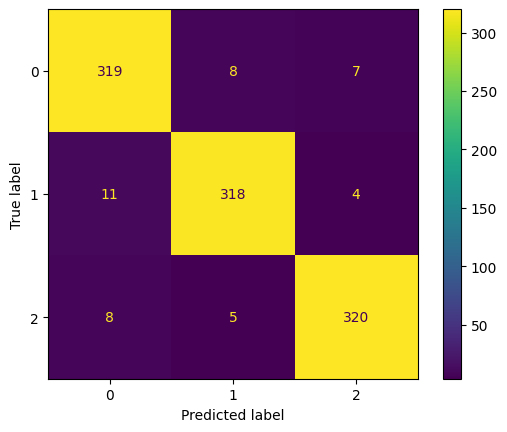

In [18]:
predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

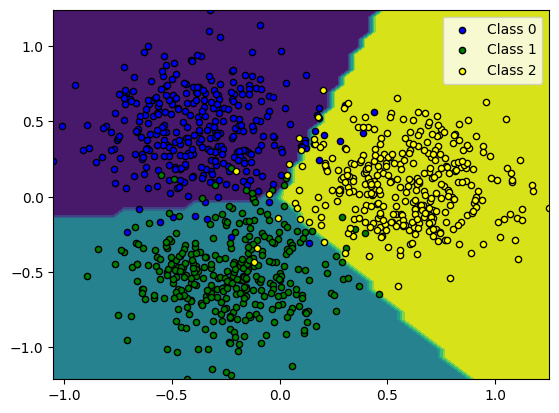

In [19]:
plot_decision_boundary_pytorch(X_test, y_test, model)

# Loss based on a cost matrix

Having a true label in a one-hot-encoding vector

$$
\mathbf{y} = [y_1, y_2, \dots, y_K]
$$

a cost matrix where each row is a true class and every column is the predicted class

$$
\mathbf{C} = \begin{bmatrix}
c_{1,1} & c_{1,2} & \dots  & c_{1,K} \\
c_{2,1} & c_{2,2} & \dots  & c_{2,K} \\
\vdots  & \vdots  & \ddots & \vdots \\
c_{K,1} & c_{K,2} & \dots  & c_{K,K} \\
\end{bmatrix}
$$

and the scores of a classifier

$$
\mathbf{s} = [s_1, s_2, \dots, s_K]
$$

We can compute the cost of predicting with a score $\mathbf{s}$ a true label $\mathbf{y}$ as

$$
\mathbf{y} \mathbf{C} \mathbf{s}^\intercal =
[y_1, y_2, \dots, y_K]
\begin{bmatrix}
c_{1,1} & c_{1,2} & \dots  & c_{1,K} \\
c_{2,1} & c_{2,2} & \dots  & c_{2,K} \\
\vdots  & \vdots  & \ddots & \vdots \\
c_{K,1} & c_{K,2} & \dots  & c_{K,K} \\
\end{bmatrix}
\begin{bmatrix}
s_1 \\ s_2 \\ \dots \\ s_K
\end{bmatrix}
$$

where, the true label $\mathbf{y}$ selects what row of the cost matrix $\mathbf{C}$ is being used as weights. The following is an example with an instantiated true label

$$
[0, 1, \dots, 0]
\begin{bmatrix}
c_{0,0} & c_{0,1} & \dots  & c_{0,K} \\
c_{1,0} & c_{1,1} & \dots  & c_{1,K} \\
\vdots  & \vdots  & \ddots & \vdots \\
c_{K,0} & c_{K,1} & \dots  & c_{K,K} \\
\end{bmatrix}
\begin{bmatrix}
s_1 \\ s_2 \\ \dots \\ s_K
\end{bmatrix}
=
[c_{1,0}, c_{1,1}, \dots, c_{1,K}]
\begin{bmatrix}
s_1 \\ s_2 \\ \dots \\ s_K
\end{bmatrix}
=
\sum_{i=1}^K c_{1,i}s_i
$$

In [20]:
C = np.array([[0, 1, 1],
              [1, 0, 1],
              [1, 1, 0]])
 
class MatrixCostLoss(nn.Module):
    def __init__(self, C):
        super(MatrixCostLoss, self).__init__()
        self.C = Variable(torch.from_numpy(C)).float()

    
    def forward(self, output, target):
        target = torch.LongTensor(target)
        target = nn.functional.one_hot(target, num_classes=3).float()
        loss = torch.einsum('ij,jk->ik', target, self.C)
        #print(target)
        #print(M)
        #print(loss)
        loss = torch.einsum('ij,ij->i', loss, output)
        #print(output)
        #print(loss)
        loss = loss.mean()
        return loss


model = NeuralNetClassifier(
    Model(input_dim=2),
    #criterion=torch.nn.BCEWithLogitsLoss,
    criterion=MatrixCostLoss(C),
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6697       0.1750        0.6623  0.0770
      2        0.6514       0.2850        0.6427  0.0746
      3        0.6327       0.5100        0.6226  0.0749
      4        0.6136       0.6400        0.6020  0.0756
      5        0.5943       0.7350        0.5813  0.0758
      6        0.5750       0.8250        0.5607  0.0775
      7        0.5559       0.8850        0.5402  0.0764
      8        0.5370       0.9200        0.5200  0.0792
      9        0.5184       0.9300        0.5003  0.0763
     10        0.5004       0.9500        0.4811  0.0780
     11        0.4828       0.9600        0.4625  0.0787
     12        0.4657       0.9700        0.4445  0.0790
     13        0.4493       0.9800        0.4272  0.0796
     14        0.4335       0.9800        0.4107  0.0784
     15        0.4183       0.9850        0.3948  0.0785
     16        0.4038       0.9

    108        0.0857       0.9750        0.0646  0.0800
    109        0.0851       0.9750        0.0640  0.0793
    110        0.0845       0.9750        0.0634  0.0795
    111        0.0839       0.9750        0.0628  0.0794
    112        0.0833       0.9750        0.0623  0.0791
    113        0.0828       0.9750        0.0617  0.0783
    114        0.0822       0.9750        0.0612  0.0798
    115        0.0817       0.9750        0.0606  0.0789
    116        0.0812       0.9750        0.0601  0.0782
    117        0.0807       0.9750        0.0596  0.0814
    118        0.0802       0.9750        0.0591  0.0783
    119        0.0797       0.9750        0.0586  0.0789
    120        0.0792       0.9750        0.0581  0.0825
    121        0.0788       0.9750        0.0577  0.0928
    122        0.0783       0.9750        0.0572  0.0767
    123        0.0779       0.9750        0.0568  0.0795
    124        0.0774       0.9750        0.0563  0.0796
    125        0.0770       0.9

    218        0.0580       0.9750        0.0372  0.0865
    219        0.0579       0.9750        0.0371  0.0865
    220        0.0578       0.9750        0.0370  0.0860
    221        0.0577       0.9750        0.0369  0.0834
    222        0.0576       0.9750        0.0369  0.0832
    223        0.0575       0.9750        0.0368  0.0829
    224        0.0575       0.9750        0.0367  0.0896
    225        0.0574       0.9750        0.0366  0.0843
    226        0.0573       0.9750        0.0365  0.0849
    227        0.0572       0.9750        0.0365  0.0877
    228        0.0571       0.9750        0.0364  0.0866
    229        0.0570       0.9750        0.0363  0.0843
    230        0.0569       0.9750        0.0362  0.0847
    231        0.0569       0.9750        0.0361  0.1122
    232        0.0568       0.9750        0.0361  0.0916
    233        0.0567       0.9750        0.0360  0.0907
    234        0.0566       0.9750        0.0359  0.0881
    235        0.0565       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=2, out_features=3, bias=True)
  ),
)

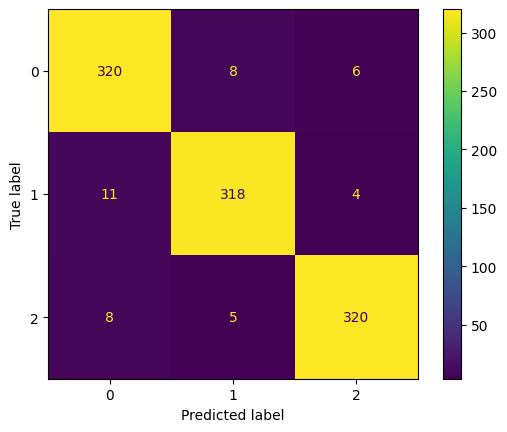

In [21]:
predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

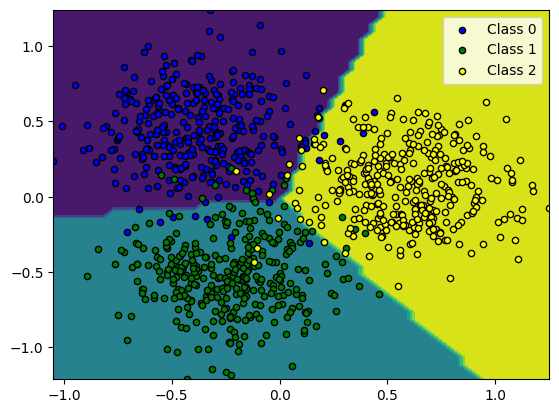

In [22]:
plot_decision_boundary_pytorch(X_test, y_test, model)

## Non-uniform Cost Matrix


We can increase the cost of predicting \textbf{class 1} when the true class is \textbf{class 2}, thus expecting less errors on the corresponding confusion matrix cell.

In [23]:
C = np.array([[0, 1, 1], 
              [9, 0, 1],
              [1, 1, 0]])

model = NeuralNetClassifier(
    Model(input_dim=2),
    #criterion=torch.nn.BCEWithLogitsLoss,
    criterion=MatrixCostLoss(C),
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)


model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3907       0.4100        2.3024  0.1010
      2        2.2295       0.4600        2.1321  0.0869
      3        2.0562       0.5250        1.9521  0.0886
      4        1.8784       0.5600        1.7720  0.0874
      5        1.7055       0.7250        1.6013  0.0901
      6        1.5454       0.8300        1.4468  0.0882
      7        1.4027       0.7800        1.3116  0.0862
      8        1.2788       0.7050        1.1957  0.0871
      9        1.1728       0.6750        1.0973  0.0890
     10        1.0826       0.6750        1.0139  0.0895
     11        1.0060       0.6700        0.9430  0.0903
     12        0.9407       0.6650        0.8825  0.1036
     13        0.8846       0.6600        0.8306  0.0940
     14        0.8362       0.6550        0.7856  0.0907
     15        0.7941       0.6500        0.7464  0.0887
     16        0.7573       0.6

    106        0.1596       0.9800        0.1180  0.0839
    107        0.1581       0.9800        0.1164  0.0825
    108        0.1566       0.9800        0.1148  0.0820
    109        0.1552       0.9800        0.1132  0.0821
    110        0.1538       0.9800        0.1117  0.0835
    111        0.1524       0.9800        0.1102  0.1046
    112        0.1511       0.9800        0.1088  0.0953
    113        0.1498       0.9800        0.1074  0.0969
    114        0.1485       0.9800        0.1060  0.0830
    115        0.1473       0.9800        0.1046  0.0824
    116        0.1461       0.9800        0.1033  0.0955
    117        0.1449       0.9800        0.1020  0.0811
    118        0.1438       0.9800        0.1008  0.0812
    119        0.1427       0.9800        0.0996  0.0808
    120        0.1416       0.9800        0.0984  0.0818
    121        0.1405       0.9750        0.0972  0.0812
    122        0.1395       0.9750        0.0960  0.0815
    123        0.1385       0.9

    216        0.0983       0.9750        0.0500  0.0861
    217        0.0982       0.9750        0.0499  0.0862
    218        0.0980       0.9750        0.0497  0.0845
    219        0.0978       0.9750        0.0495  0.0845
    220        0.0977       0.9750        0.0493  0.0852
    221        0.0975       0.9750        0.0492  0.0851
    222        0.0974       0.9750        0.0490  0.0867
    223        0.0972       0.9750        0.0488  0.1010
    224        0.0971       0.9750        0.0487  0.0811
    225        0.0969       0.9750        0.0485  0.0818
    226        0.0968       0.9750        0.0483  0.0805
    227        0.0967       0.9750        0.0482  0.0823
    228        0.0965       0.9750        0.0480  0.0816
    229        0.0964       0.9750        0.0479  0.0817
    230        0.0962       0.9750        0.0477  0.0815
    231        0.0961       0.9750        0.0476  0.0826
    232        0.0960       0.9750        0.0474  0.0820
    233        0.0958       0.9

    326        0.0884       0.9700        0.0391  0.0897
    327        0.0883       0.9700        0.0390  0.0894
    328        0.0883       0.9700        0.0390  0.0797
    329        0.0882       0.9700        0.0389  0.0845
    330        0.0882       0.9700        0.0389  0.0847
    331        0.0881       0.9700        0.0388  0.0914
    332        0.0881       0.9700        0.0388  0.0808
    333        0.0880       0.9700        0.0387  0.0853
    334        0.0880       0.9700        0.0387  0.0839
    335        0.0879       0.9700        0.0386  0.0847
    336        0.0879       0.9700        0.0386  0.0845
    337        0.0878       0.9700        0.0385  0.0843
    338        0.0878       0.9700        0.0385  0.0844
    339        0.0878       0.9700        0.0384  0.0839
    340        0.0877       0.9700        0.0384  0.0959
    341        0.0877       0.9700        0.0383  0.0842
    342        0.0876       0.9700        0.0383  0.0838
    343        0.0876       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=2, out_features=3, bias=True)
  ),
)

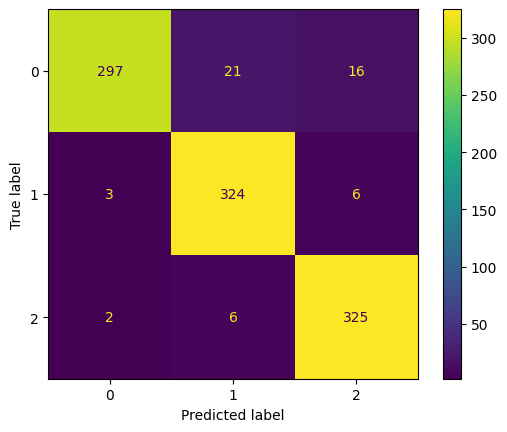

In [24]:
predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

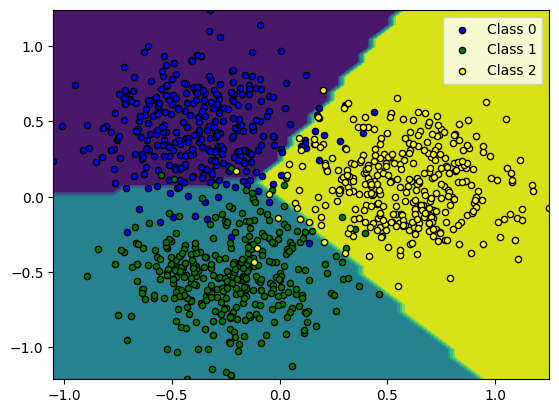

In [25]:
plot_decision_boundary_pytorch(X_test, y_test, model)